# ML workflow for the house prices dataset

This script contains a machine learning workflow for the house prices dataset. The workflow is based on scikit-learn pipelines. Different model architectures are used, including xgb, random forest, lgbm and ridge regression. Following grid search, models are combined in an ensemble to provide the final estimate.

In [1]:
# load libraries
import pandas as pd
import numpy as np
import pickle
import warnings
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Print file names in directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitions/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/competitions/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/competitions/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/competitions/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/datasets/cedricga/eda-config/eda_config.pickle


In [2]:
# define necessary functions
def encode_ordinal(df, columns, order):
    for column in columns:
        df[column] = (
            pd.Categorical(df[column], categories=order, ordered=True)
            .codes
            .astype('float')
        )
        df[column] = df[column].replace(-1, np.nan)
    return df

# define function to run parameter grid search together with cross-validation
# important to specify scoring to negative RMSE (in line with kaggle)
def run_grid_search(estimator, param_grid, preprocessor, X, y, cv, scoring="neg_root_mean_squared_error"):
    
    # define pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])

    # set-up grid search
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv, # k-fold variable must be defined before so random state is always the same
        scoring=scoring,
        return_train_score=True
    )

    # run grid search
    grid.fit(X, y)

    # Extract results across runs (this runs independent of how many parameters are specified)
    results_df = pd.DataFrame({
        key.replace("param_model__", ""): grid.cv_results_[key]
        for key in grid.cv_results_.keys()
        if key.startswith("param_model__")
    })

    results_df["mean_rmse"] = -grid.cv_results_["mean_test_score"]  # Negate so that the final score is shown as positive
    results_df["std_rmse"] = grid.cv_results_["std_test_score"]

    return grid, results_df.sort_values("mean_rmse")

## Feature Engineering

In [12]:
# specify input paths
train_file_path = '/kaggle/input/competitions/house-prices-advanced-regression-techniques/train.csv'
test_file_path = '/kaggle/input/competitions/house-prices-advanced-regression-techniques/test.csv'
submission_file_path = '/kaggle/input/competitions/house-prices-advanced-regression-techniques/sample_submission.csv'
eda_config_file_path = '/kaggle/input/datasets/cedricga/eda-config/eda_config.pickle'

# load as pandas data frames
df = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)
sub_df = pd.read_csv(submission_file_path)

# load eda config file
with open(eda_config_file_path, 'rb') as handle:
    eda = pickle.load(handle)

# separate variables
target = df["SalePrice"]
df = df.drop(columns=["SalePrice"])

# display options
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

In [13]:
# show dict keys of eda results
for i in eda.keys():
    print(i)

cols_na_fill
na_fill_term
bin_cat_vars
drop_features
ordinal_maps
dtype_overrides
numeric_features
categorical_features
rare_category_features
skewed_features
outlier_sensitive_features
target_transform
numeric_predictors_correlation
categorical_predictors_etasquared
high_corr_pairs_numeric
high_association_pairs_categorical


First, the dataframe will be adjusted based on the results of the exploratory data analysis.

In [14]:
# recode NA values
df[eda['cols_na_fill']] = df[eda['cols_na_fill']].fillna(eda['na_fill_term'])

# recode into ordinal variables
for col, mapping in eda['ordinal_maps'].items():
    df = encode_ordinal(df, [col], mapping)
    df_test = encode_ordinal(df_test, [col], mapping)

# fix dtype
for col, dtype in eda['dtype_overrides'].items():
    df[col] = df[col].astype(dtype)
    df_test[col] = df_test[col].astype(dtype)

# log-transform target
target = np.log1p(target) # log-transformation takes care of the usual right-skew of price distributions

Next, I'll add binary features for the previously identified ordinal columns with no associated binary features as well as the year sold

In [15]:
# wrap in function since it needs to be applied to the df and test df
def add_features(df):
    df = df.copy()

    df['YrSoldBin'] = pd.cut(
        x=df['YrSold'],
        bins=[-np.inf,2007,np.inf],
        labels=[0,1]
    ).astype(int)
    
    df['HasBasement'] = df['BsmtQual'].notna().astype(int)
    df['HasGarage'] = df['GarageQual'].notna().astype(int)
    df['HasFence'] = df['Fence'].notna().astype(int)
    df['HasMiscFeature'] = df['MiscFeature'].notna().astype(int)

    return df

In [16]:
df = add_features(df)
df_test = add_features(df_test)

## Pipeline Set-Up

The EDA previously identified several skewed numeric variables with outliers. Categorical variables were also shown to have some rare categories. The preprocessing pipeline can take this into account by scaling numeric variables and combining infrequent categories. Collapsing infrequent categories has the benefit of reducing the required columns for one-hot-encoding.

In [17]:
# split into numeric and categorical
numeric_features = eda['numeric_features']
categorical_features = eda['categorical_features']
binary_features = ['YrSoldBin','HasBasement','HasGarage','HasFence','HasMiscFeature']

In [18]:
# preprocessing numerical features (insert median for missing values and use z-score scaling)
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')), # impute the median for missing values
    ('scaler',  RobustScaler()) # this ensures outliers and skew are minimized
])


# preprocessing categorical features (insert most frequent for missing values)
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')), # impute most frequent category if missing
    ('onehot', OneHotEncoder( # this is set up so that rare categories are grouped into a 'other' category
        handle_unknown = 'infrequent_if_exist',
        min_frequency = 0.01)) # this takes care of rare categories that appear less than 1%
])

# preprocessing binary features (insert most frequent for missing values)
binary_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent'))
])

In [19]:
# define the columns transformer
preprocessor = ColumnTransformer(transformers = [
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('bin', binary_transformer, binary_features)
])

# prepare the train and test datasets
X = df[numeric_features + categorical_features + binary_features]
X_test = df_test[numeric_features + categorical_features + binary_features]

## Baseline Regressor: XGB

The EDA has shown that there are a few pairs of variables with high correlation. Therefore, I will first use tree-based models since they are robust to multicollinearity.

In [20]:
# set random seed
rs = 42
np.random.seed(rs)

# define kfold split
kf = KFold(n_splits=5, shuffle=True, random_state=rs)

param_grid = {
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [200, 250, 300],
    'model__learning_rate': [0.05, 0.1, 0.2]
}

estimator = XGBRegressor(random_state=rs)

grid_xgb, results_xgb = run_grid_search(
    estimator, param_grid, preprocessor, X, target, kf,
    scoring="neg_root_mean_squared_error"
)
results_xgb.head()

,learning_rate,max_depth,n_estimators,mean_rmse,std_rmse
11,0.10,3,300,0.130304,0.018348
10,0.10,3,250,0.130524,0.018633
9,0.10,3,200,0.130896,0.018986
5,0.05,4,300,0.131864,0.016351
14,0.10,4,300,0.131923,0.016275


In [21]:
# get the model parameters with best RMSE estimate
model = grid_xgb.best_estimator_

# train the model and predict test data
model.fit(X,target)
target_pred = model.predict(X_test)

In [22]:
# create results dataframe
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': np.expm1(target_pred) # take inverse of logarithm for kaggle competition
})

# save in .csv format
submission.to_csv("submission_XGBRegressor.csv", index=False)

The basic XGB Regressor has a test RMSE of 0.1316 (kaggle leaderboard). This estimate is similar to the cross-validated RMSE. However, there's several things left to do to try and increase the accuracy of the predictions. In the next step, let's define more models.

## Model Comparison: Random Forest, Ridge and More

Let's run several other models including the very similar random forest regressor as well as LGBM and the linear ridge estimator. These models probably won't be much better than XGB, but it might be helpful to combine these into an ensemble later, especially the ridge regressor.

In [23]:
param_grid = {
    'model__max_depth': [3, 6, 9, 12],
    'model__n_estimators': [100, 200, 250]
}

estimator = RandomForestRegressor(random_state=rs)

grid_rf, results_rf = run_grid_search(
    estimator, param_grid, preprocessor, X, target, kf,
    scoring="neg_root_mean_squared_error"
)
results_rf.head()

,max_depth,n_estimators,mean_rmse,std_rmse
10,12,200,0.143819,0.018694
11,12,250,0.143939,0.018863
9,12,100,0.144657,0.018954
8,9,250,0.145725,0.018598
7,9,200,0.145743,0.018467


In [24]:
param_grid = {
    'model__max_depth': [3, 6, 9, 12],
    'model__n_estimators': [100, 200, 250],
    'model__learning_rate': [0.05, 0.1]
}

estimator = LGBMRegressor(
    random_state=rs,
    verbose=-1,
    n_jobs=-1,
    enable_categorical=True
)

warnings.filterwarnings("ignore", message="X does not have valid feature names") # suppress error message, regressor will still run

grid_lgbm, results_lgbm = run_grid_search(
    estimator, param_grid, preprocessor, X, target, kf,
    scoring="neg_root_mean_squared_error"
)
results_lgbm.head()

,learning_rate,max_depth,n_estimators,mean_rmse,std_rmse
2,0.05,3,250,0.132337,0.018308
14,0.10,3,250,0.132574,0.018226
13,0.10,3,200,0.132792,0.018289
1,0.05,3,200,0.133208,0.018173
4,0.05,6,200,0.133937,0.017931


In [25]:
param_grid = {
    'model__kernel': ['rbf'],
    'model__C': [70, 100, 150],
    'model__gamma': ['scale']
}

estimator = SVR()

grid_svr, results_svr = run_grid_search(
    estimator, param_grid, preprocessor, X, target, kf,
    scoring="neg_root_mean_squared_error"
)
results_svr.head()

,C,gamma,kernel,mean_rmse,std_rmse
2,150,scale,rbf,0.186082,0.020627
1,100,scale,rbf,0.186795,0.019683
0,70,scale,rbf,0.189392,0.017976


Let's test a linear model next. It's important to use a model with regularization, such as Ridge, since our dataset contains variables that are highly correlated with each other

In [26]:
param_grid = {
    'model__alpha': np.linspace(0.1, 3, 5)
}

estimator = Ridge(random_state=rs)

grid_rid, results_rid = run_grid_search(
    estimator, param_grid, preprocessor, X, target, kf,
    scoring="neg_root_mean_squared_error"
)
results_rid.head()

,alpha,mean_rmse,std_rmse
4,3.000,0.148130,0.037318
3,2.275,0.148474,0.037148
2,1.550,0.148918,0.036973
1,0.825,0.149557,0.036799
0,0.100,0.150845,0.036564


In [27]:
param_grid = {
    'model__n_neighbors':[2,5,10,20,30]
}

estimator = KNeighborsRegressor()

grid_kn, results_kn = run_grid_search(
    estimator, param_grid, preprocessor, X, target, kf,
    scoring="neg_root_mean_squared_error"
)
results_kn.head()

,n_neighbors,mean_rmse,std_rmse
2,10,0.245946,0.020751
3,20,0.246548,0.016337
4,30,0.246569,0.016316
1,5,0.252432,0.020780
0,2,0.256396,0.018716


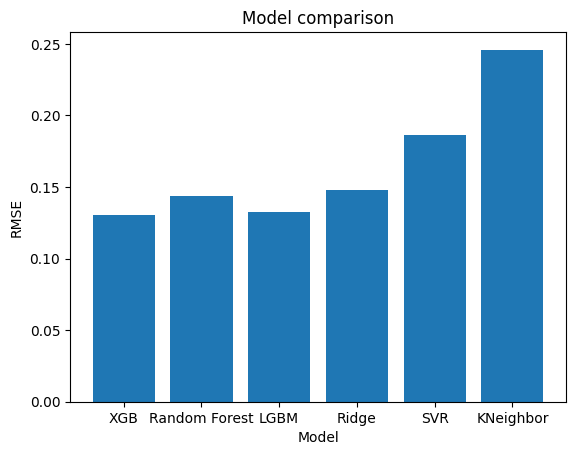

In [28]:
# plot the scores of all the different models
rmse = [
    results_xgb.mean_rmse.iloc[0],
    results_rf.mean_rmse.iloc[0],
    results_lgbm.mean_rmse.iloc[0],
    results_rid.mean_rmse.iloc[0],
    results_svr.mean_rmse.iloc[0],
    results_kn.mean_rmse.iloc[0]
]

model = [
    'XGB',
    'Random Forest',
    'LGBM',
    'Ridge',
    'SVR',
    'KNeighbor'
]

plt.bar(model, rmse)
plt.title('Model comparison')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

There are four models that perform relatively similar, including XGB, Random forest, LGBM and Ridge. The SVR and K-Nearest neighbor models seem to perform noticeably worse. Let's build an ensemble or stack using the first four models and exclude SVR and KNeighbor.

## Ensemble learning

In [29]:
# combine models into an ensemble
ensemble = VotingRegressor([
    ('xgb', grid_xgb.best_estimator_),
    ('rf', grid_rf.best_estimator_),
    ('lgbm', grid_lgbm.best_estimator_),
    ('ridge', grid_rid.best_estimator_),
])

# get a cv score
ensemble_cv = cross_val_score(ensemble,X, target, cv=kf, scoring = "neg_root_mean_squared_error")
print('Mean RMSE: ' + str(-np.mean(ensemble_cv)))

Mean RMSE: 0.12896086668310058


In [30]:
# fit the model
ensemble.fit(X, target)

target_pred = ensemble.predict(X_test)

# create results dataframe
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': np.expm1(target_pred) # take inverse of logarithm for kaggle competition
})

# save in .csv format
submission.to_csv("submission_ensemble.csv", index=False)

The test RMSE from the ensemble submission is 0.128, significantly better than XGB alone. However, instead of the voting regressor, let's try the stacking regressor.

In [31]:
stack = StackingRegressor([
    ('xgb', grid_xgb.best_estimator_),
    ('rf', grid_rf.best_estimator_),
    ('lgbm', grid_lgbm.best_estimator_),
    ('ridge', grid_rid.best_estimator_)
], final_estimator=Ridge())

# get a cv score
stack_cv = cross_val_score(stack,X, target, cv=kf, scoring = "neg_root_mean_squared_error")
print('Mean RMSE: ' + str(-np.mean(stack_cv)))

Mean RMSE: 0.13078762135128663


In [32]:
# fit the model
stack.fit(X, target)

target_pred = stack.predict(X_test)

# create results dataframe
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': np.expm1(target_pred) # take inverse of logarithm for kaggle competition
})

# save in .csv format
submission.to_csv("submission_stack.csv", index=False)

Using the stack slightly decreased the RMSE to 0.124. Ridge was used as the final meta regressor since linear models tend to perform better there.

## Summary

 The stack predicted sales prices accurately within a margin of error of 13% (conversion of log-RMSE). Based on the kaggle-leaderboard, this model lands in the top 15% of submissions.